In [1]:
import numpy as np
import sympy
import scipy
import underworld3 as uw
import matplotlib.pyplot as plt

# Step 1: Create Model FIRST
model = uw.Model()

# Step 2: Define the unit system

model.set_reference_quantities(
    length=uw.quantity(1000, "km"),
    diffusivity=uw.quantity(1e-6, "m**2/s"),
    density=uw.quantity(3000, "kg/m**3"),
    temperature=uw.quantity(1000, "K"), 
    verbose=False,
    nondimensional_scaling=True, # The default !
)

uw.use_nondimensional_scaling(True) 


L_domain = uw.quantity(2900, "km")           # Domain width
H_domain = uw.quantity(1000, "km")           # Domain height
T_left = uw.quantity(273, "K")               # Left boundary temperature (cold)
T_right = uw.quantity(1573, "K")             # Right boundary temperature (hot)
kappa = uw.expression(r"\kappa", uw.quantity(1e-6, "m**2/s"), "thermal diffusivity")    
rho = uw.expression(r"\rho", uw.quantity(3000, "kg/m**3"), "density")    

# Step 3: Create mesh (AFTER model and unit system are set up)
res = 20
cellSize_phys = L_domain / res

mesh = uw.meshing.UnstructuredSimplexBox(
    minCoords=(0 * uw.units.km, 0 * uw.units.km),
    maxCoords=(L_domain, H_domain),
    cellSize=cellSize_phys,
    regular=False,
    qdegree=3,
)

# Verify mesh units
x, y = mesh.CoordinateSystem.X

# Create mesh variables
T = uw.discretisation.MeshVariable("T", mesh, 1, degree=3, units="K")
T0 = uw.discretisation.MeshVariable("T_0", mesh, 1, degree=3, units="K")
v = uw.discretisation.MeshVariable("v", mesh, mesh.dim, degree=1, units="cm/yr")


PostHog telemetry failed: HTTPSConnectionPool(host='eu.i.posthog.com', port=443): Max retries exceeded with url: /capture/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x306eb3200>: Failed to resolve 'eu.i.posthog.com' ([Errno 8] nodename nor servname provided, or not known)"))
✓ Units system active with automatic non-dimensionalization


In [2]:
model.get_fundamental_scales()

{'length': <Quantity(1000000.0, 'meter')>,
 'time': <Quantity(1e+18, 'second')>,
 'mass': <Quantity(3e+21, 'kilogram')>,
 'temperature': <Quantity(1000.0, 'kelvin')>}

# Analytical Solution in Physical Units
</br>

The error function solution for an advected step with diffusion:

$$T(x,t) = T_{\text{left}} + (T_{\text{right}} - T_{\text{left}}) \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{x - x_0 - ut}{2\sqrt{\kappa t}}\right)\right]$$

In [3]:
t_now = uw.expression(r"t_\textrm{now}", uw.quantity(50, 'Myr'), "Current time")
velocity = uw.expression(r"V_0", uw.quantity(2.5, "mm/yr"), "Advection velocity")   # Horizontal velocity
xx0 =  uw.expression(r"x_0", uw.quantity(375, 'km'), "Initial position") 

theta = uw.expression(r"\Theta", (x - xx0 - velocity*t_now)  / (2*(kappa * t_now)**0.5), "Theta")


In [4]:
# Here is how we update the t_now / velocity values if we need to - preserves lazy evaluation for theta
# t_now.sym = uw.quantity(40, 'Myr')
# velocity.sym = uw.quantity(1, "cm/yr")

In [5]:
T_analytical = T_left + (T_right-T_left) * (sympy.sympify(1)/2 + sympy.erf(theta)/2) 
T.array[...] = uw.function.evaluate(T_analytical, T.coords)
T0.data[...] = T.data[...]

T_initial_array = T0.array[...].magnitude.squeeze().copy()

In [6]:
uw.function.evaluate( uw.quantity(2000, 'km') / velocity, mesh.X.coords[0]).to("Myr")

UnitAwareArray([[[800.]]]), callbacks=0, units='megayear')

In [7]:
# Compare this to the above

display(T_analytical)
uw.pprint("where")
display(theta)

1300\ \mathrm{K}*(erf(\Theta)/2 + 1/2) + 273\ \mathrm{K}

where


<IPython.core.display.Latex object>

In [8]:
with uw.synchronised_array_update():
    v.array[:,0,1] = uw.quantity(0, "cm/yr")
    v.array[:,0,0] = velocity.sym
    

In [9]:
# Just a reminder !
uw.quantity(2.5,"mm/yr").to("km/Myr")

# 1000 km would be 400 Myr

<IPython.core.display.Latex object>

In [10]:
# Create advection-diffusion solver
adv_diff = uw.systems.AdvDiffusion(
    mesh,
    u_Field=T,
    V_fn=v,
    order=1,
)

# Set diffusivity (physical units!)
adv_diff.constitutive_model = uw.constitutive_models.DiffusionModel
adv_diff.constitutive_model.Parameters.diffusivity = kappa

print(f"Diffusivity     : {adv_diff.constitutive_model.Parameters.diffusivity}")
print(f"Diffusivity (ND): {adv_diff.constitutive_model.Parameters.diffusivity.data}")

# Apply boundary conditions (Dirichlet on left and right)
adv_diff.add_dirichlet_bc(T_left, "Left")
adv_diff.add_dirichlet_bc(T_right, "Right")


Diffusivity     : 1e-06 [meter ** 2 / second]
Diffusivity (ND): 1.0


In [11]:
adv_diff.estimate_dt().to("Myr")

<IPython.core.display.Latex object>

In [12]:
# Time stepping loop
model_time = t_now
time_history = [model_time]
dt_estimate = uw.quantity(50, "Myr")

step = 0

while model_time.sym < uw.quantity(750, "Myr"):
    # Solve for one time step (dt in seconds)
    adv_diff.solve(timestep=dt_estimate)
    model_time.sym = model_time.sym + dt_estimate
    time_history.append(model_time)
    
    print(f"Step {step+1:3d} t = {model_time}")

    step += 1

print(f"Time stepping complete")
print(f"Final time: {model_time}")

Step   1 t = 100 [megayear]
Step   2 t = 150 [megayear]
Step   3 t = 200 [megayear]
Step   4 t = 250 [megayear]
Step   5 t = 300 [megayear]
Step   6 t = 350 [megayear]
Step   7 t = 400 [megayear]
Step   8 t = 450 [megayear]
Step   9 t = 500 [megayear]
Step  10 t = 550 [megayear]
Step  11 t = 600 [megayear]
Step  12 t = 650 [megayear]
Step  13 t = 700 [megayear]
Step  14 t = 750 [megayear]
Time stepping complete
Final time: 750 [megayear]


In [13]:
(cellSize_phys**2 / kappa).to_base_units().to("Myr")

<IPython.core.display.Latex object>

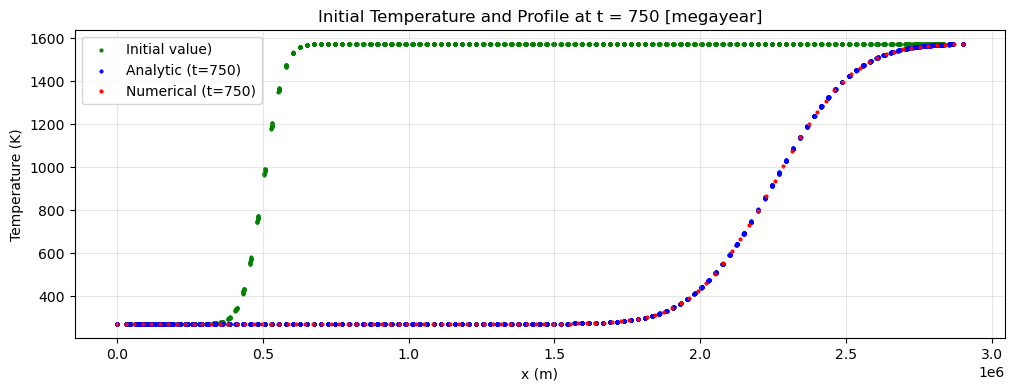

In [14]:
# Visualize initial condition
fig, ax = plt.subplots(figsize=(12, 4))

# Sample along horizontal line at mid-height
sample_x_km = np.linspace(0, L_domain.to("km").magnitude, 100)
sample_y_km = np.zeros_like(sample_x_km) + H_domain.to("km").magnitude / 2
sample_points = np.column_stack([sample_x_km * 1000, sample_y_km * 1000])  # Convert to meters
sample_points_units = uw.utilities.UnitAwareArray(sample_points, units=uw.units.m)

T_profile = uw.function.evaluate(T, sample_points_units).squeeze().magnitude
T_anal_array =  uw.function.evaluate(T_analytical, T.coords).squeeze().magnitude

ax.scatter(T.coords[:,0].magnitude, T_initial_array  , 1, 'green', linewidth=2, label=f'Initial value)')
ax.scatter(T.coords[:,0].magnitude, T_anal_array  , 1, 'blue', linewidth=2, label=f'Analytic (t={t_now.value})')
ax.scatter(sample_points[:,0], T_profile, 1, 'red', linewidth=2, label=f'Numerical (t={t_now.value})')

# ax.axvline(x=x0_at_start/1000, color='purple', linestyle='--', 
#            alpha=0.6, linewidth=2, label=f'Step center at {x0_at_start/1000:.0f} km')
#ax.set_xlim(1e6, 2e6)
ax.set_xlabel('x (m)')
ax.set_ylabel('Temperature (K)')
ax.set_title(f'Initial Temperature and Profile at t = {t_now}')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()